In [4]:
import torch
import transformers
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.nn import CrossEntropyLoss, MSELoss
from tqdm import tqdm
import re
import pandas as pd
import emoji
from nltk.stem import WordNetLemmatizer, PorterStemmer
from torch.optim import Adam, SGD
from transformers import get_scheduler
import gc
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv('HateBR.csv')
df

,instagram_comments,offensive_language,offensiveness_levels,hate_speech
0,este lixo ...,1,1,-1
1,Mais um lixo,1,1,-1
2,Essa nao tem vergonha na cara!!,1,2,-1
3,Essa mulher é doente.pilantra!,1,3,-1
4,Comunista safada...,1,2,"5,8"
...,...,...,...,...
6995,Time perdendo a credibilidade,0,0,0
6996,Siga em frente Presidente Bolsonaro! Afinal o ...,0,0,0
6997,Tantas coisas importantes para resolver e fica...,0,0,0
6998,"A TIME escolhe quem eles quiser, isso não sign...",0,0,0


Grid Search Progress:   0%|          | 0/486 [00:00<?, ?it/s]Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Grid Search Progress:   0%|          | 1/486 [04:29<36:19:41, 269.65s/it]Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Grid Search Progress:   0%|          | 2/486 [08:57<36:07:58, 268.76s/it]Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN

Melhores parâmetros: {'learning_rate': 3e-05, 'optimizer': 'AdamW', 'loss_function': 'CrossEntropyLoss', 'batch_size': 8, 'epochs': 5, 'preprocess_option': {'remove_emoji': True, 'remove_numbers': False, 'lemmatize': True, 'stem': True, 'to_lower': True, 'remove_punctuation': False}}
Melhor F1-Score: 0.8964093789136632


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\celso\miniconda3\envs\PET_torch\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training Final Model: 100%|██████████| 5/5 [06:49<00:00, 81.95s/it]


Accuracy: 0.8714285714285714
F1-Score: 0.8714311953406318
Precision: 0.871789564047468
Recall: 0.8714285714285714


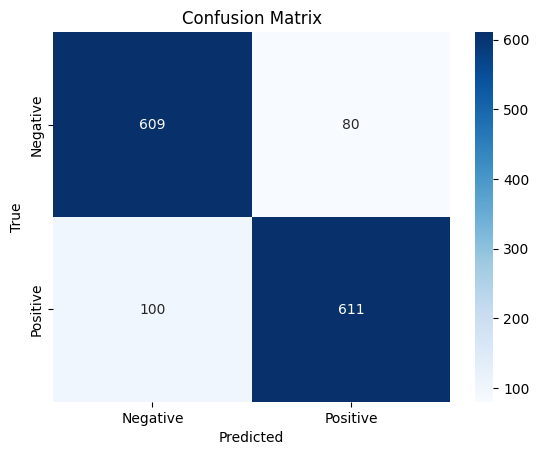

In [6]:
import torch
import transformers
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.nn import CrossEntropyLoss, MSELoss
from tqdm import tqdm
import re
import emoji
from nltk.stem import WordNetLemmatizer, PorterStemmer
from torch.optim import Adam, SGD
from transformers import get_scheduler
import gc
import seaborn as sns
import matplotlib.pyplot as plt

# Função de pré-processamento do texto
def preprocess_text(text, remove_emoji=True, remove_numbers=True, lemmatize=True, stem=True, to_lower=True, remove_punctuation=True):
    if remove_emoji:
        text = emoji.replace_emoji(text, replace="")
    if remove_numbers:
        text = re.sub(r'\d+', '', text)
    if to_lower:
        text = text.lower()
    if remove_punctuation:
        text = re.sub(r'[!"#$%&\'()*+,\-./:;<=>?@[\\]^_`{|}~]', ' ', text)
    if lemmatize:
        lemmatizer = WordNetLemmatizer()
        text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    if stem:
        stemmer = PorterStemmer()
        text = ' '.join([stemmer.stem(word) for word in text.split()])
    return text

# Dataset personalizado
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Função para treinar o modelo
def train_model(model, train_loader, val_loader, optimizer, scheduler, loss_fn, epochs=5, device='cuda'):
    model.to(device)
    best_f1 = 0
    for epoch in range(epochs):
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            scheduler.step()

        model.eval()
        val_preds, val_labels = [], []
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                outputs = model(input_ids, attention_mask=attention_mask)
                preds = torch.argmax(outputs.logits, dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        f1 = f1_score(val_labels, val_preds, average='weighted')
        best_f1 = max(best_f1, f1)

    return best_f1

# Limpeza de memória
def clear_memory():
    gc.collect()
    torch.cuda.empty_cache()

# Carregar dados
texts = df['instagram_comments'].apply(preprocess_text).tolist()
labels = df['offensive_language'].tolist()

# Divisão dos dados
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Hiperparâmetros para Grid Search
learning_rates = [1e-5, 3e-5, 5e-5]
optimizers = [Adam, SGD, AdamW]
loss_functions = [CrossEntropyLoss(), MSELoss()]
batch_sizes = [8, 16, 32]
epochs_options = [3, 4, 5]
preprocess_options = [
    {'remove_emoji': True, 'remove_numbers': True, 'lemmatize': True, 'stem': True, 'to_lower': True, 'remove_punctuation': True},
    {'remove_emoji': False, 'remove_numbers': True, 'lemmatize': True, 'stem': False, 'to_lower': True, 'remove_punctuation': True},
    {'remove_emoji': True, 'remove_numbers': False, 'lemmatize': True, 'stem': True, 'to_lower': True, 'remove_punctuation': False}
]

best_f1 = 0
best_params = {}

# Inicializar tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Calcular o número total de experimentos
total_experiments = len(learning_rates) * len(optimizers) * len(loss_functions) * len(batch_sizes) * len(epochs_options) * len(preprocess_options)
progress_bar = tqdm(total=total_experiments, desc="Grid Search Progress")

# Grid Search
for lr in learning_rates:
    for optimizer_class in optimizers:
        for loss_fn in loss_functions:
            for batch_size in batch_sizes:
                for epochs in epochs_options:
                    for preprocess_option in preprocess_options:
                        clear_memory()

                        # Pré-processar os textos com as opções atuais
                        processed_train_texts = [preprocess_text(t, **preprocess_option) for t in train_texts]
                        processed_val_texts = [preprocess_text(t, **preprocess_option) for t in val_texts]

                        # Criar datasets e dataloaders
                        train_dataset = CustomDataset(processed_train_texts, train_labels, tokenizer, max_len=128)
                        val_dataset = CustomDataset(processed_val_texts, val_labels, tokenizer, max_len=128)
                        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
                        val_loader = DataLoader(val_dataset, batch_size=batch_size)

                        # Modelo e otimizador
                        model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
                        optimizer = optimizer_class(model.parameters(), lr=lr)
                        scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * epochs)

                        # Treinar e avaliar
                        f1 = train_model(model, train_loader, val_loader, optimizer, scheduler, loss_fn, epochs=epochs)

                        # Atualizar melhores parâmetros
                        if f1 > best_f1:
                            best_f1 = f1
                            best_params = {
                                'learning_rate': lr,
                                'optimizer': optimizer_class.__name__,
                                'loss_function': loss_fn.__class__.__name__,
                                'batch_size': batch_size,
                                'epochs': epochs,
                                'preprocess_option': preprocess_option
                            }

                        progress_bar.update(1)

progress_bar.close()
print("Melhores parâmetros:", best_params)
print("Melhor F1-Score:", best_f1)

# Treinando e avaliando com os melhores parâmetros
clear_memory()
processed_train_texts = [preprocess_text(t, **best_params['preprocess_option']) for t in train_texts]
processed_val_texts = [preprocess_text(t, **best_params['preprocess_option']) for t in val_texts]

train_dataset = CustomDataset(processed_train_texts, train_labels, tokenizer, max_len=128)
val_dataset = CustomDataset(processed_val_texts, val_labels, tokenizer, max_len=128)
train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=best_params['batch_size'])

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
optimizer = eval(best_params['optimizer'])(model.parameters(), lr=best_params['learning_rate'])
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * best_params['epochs'])
loss_fn = eval(best_params['loss_function'])

model.to('cuda')
model.train()
progress_bar = tqdm(range(best_params['epochs']), desc="Training Final Model")
for epoch in progress_bar:
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to('cuda')
        attention_mask = batch['attention_mask'].to('cuda')
        labels = batch['labels'].to('cuda')
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()

# Avaliação final
model.eval()
val_preds, val_labels = [], []
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to('cuda')
        attention_mask = batch['attention_mask'].to('cuda')
        labels = batch['labels'].to('cuda')
        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)
        val_preds.extend(preds.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(val_labels, val_preds)
f1 = f1_score(val_labels, val_preds, average='weighted')
precision = precision_score(val_labels, val_preds, average='weighted')
recall = recall_score(val_labels, val_preds, average='weighted')
cm = confusion_matrix(val_labels, val_preds)

print(f"Accuracy: {accuracy}")
print(f"F1-Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
